In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation_Test import sys_dataset

# Varying sigma of spatial model

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

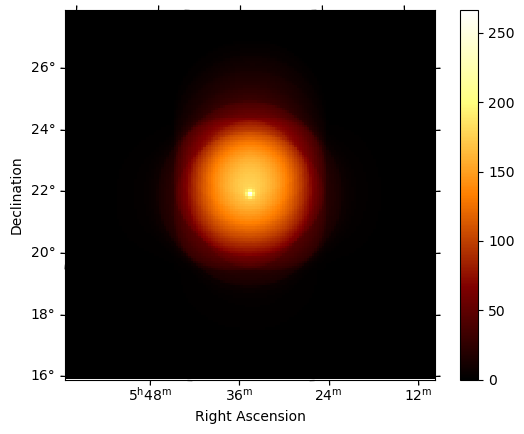

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1"
)

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Varying the Exposure

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

# energy independent method: pm 10% for reconstructed energy
shift_neg = -0.1#-0.085
shift_pos = 0.1#0.085
shift_cor = 0.0

tilt_neg = -0.015 # 1e-25 for computational purposes -> covmatrix "1/0"
tilt_pos = 0.015
tilt_cor = 0.0

### Varying Amplitude

In [5]:
amplitude = 1e-12

sigma_spatial_array = [0.02, 0.05, 0.1]

In [6]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

In [7]:
#initialize asimov datasets with different sigma_spatial
dataset_asimov_array = []
for i, a in enumerate(sigma_spatial_array):
    dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
    # Create the spatial model 
    model_spatial = GaussianSpatialModel(
        lon_0="83.631 deg",
        lat_0="22.018 deg",
        sigma=f"{a} deg",
        )

    # Create the spectral model 
    model_spectrum  = ExpCutoffPowerLawSpectralModel(
        index=2.3,
        amplitude=f"{amplitude} TeV-1 cm-2 s-1",
        lambda_="0.1 TeV-1"
    )

    # combine the spectral and the spatial model
    source_model = SkyModel(spatial_model = model_spatial ,
                           spectral_model = model_spectrum,
                           name = "Source")    
    models = Models(source_model)

    # Create the model for the Background
    bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
    bkg_model.parameters['tilt'].frozen  = False
    models.append(bkg_model)

    # set the models in the dataset
    dataset_asimov.models = models
    # set counts
    dataset_asimov.counts = dataset_asimov.npred()
    
    dataset_asimov_array.append(dataset_asimov)

In [8]:
datasets_array = []
for i, a in enumerate(sigma_spatial_array):
    sys_d_cor = sys_dataset(dataset_asimov_array[i], shift_cor, tilt_cor, False, amplitude, a)
    dataset_cor = sys_d_cor.create_dataset()

    sys_d_neg = sys_dataset(dataset_asimov_array[i], shift_neg, tilt_neg, False, amplitude, a)
    dataset_neg = sys_d_neg.create_dataset()

    sys_d_pos = sys_dataset(dataset_asimov_array[i], shift_pos, tilt_pos, False, amplitude, a)
    dataset_pos = sys_d_pos.create_dataset()
    
    datasets_array.append([dataset_neg, dataset_cor, dataset_pos])
    
dataset_neg_typ = datasets_array[0][0] #with typical parameters
dataset_cor_typ = datasets_array[0][1]
dataset_pos_typ = datasets_array[0][2]
#print(datasets_array[1][2])

In [9]:
exposure_pos = dataset_pos.exposure
exposure_neg = dataset_neg.exposure

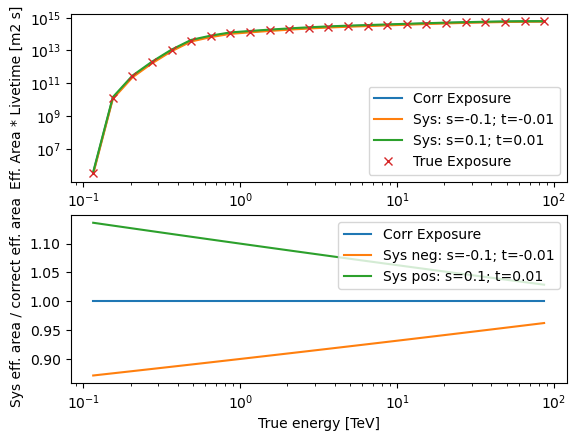

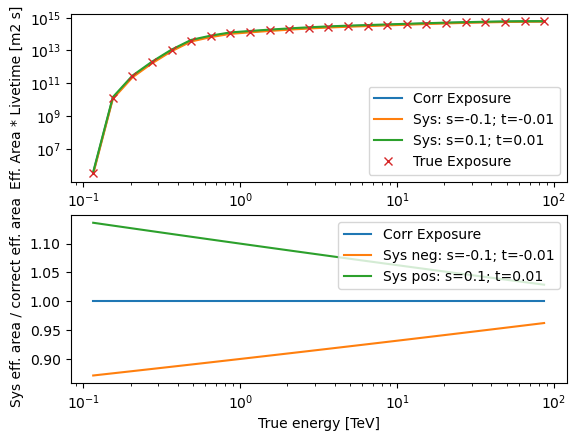

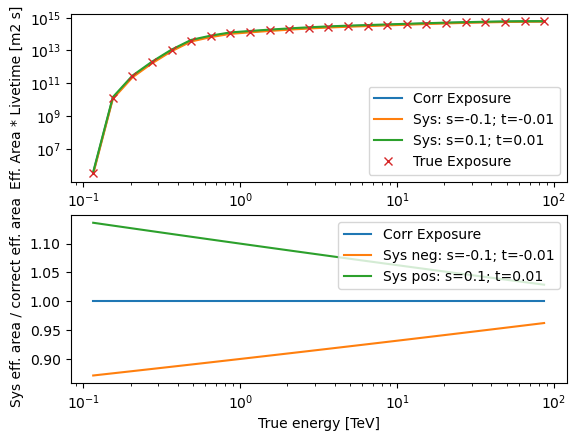

In [10]:
for i, a in enumerate(sigma_spatial_array):
    dataset_asimov = dataset_asimov_array[i]
    dataset_neg = datasets_array[i][0]
    dataset_cor = datasets_array[i][1]
    dataset_pos = datasets_array[i][2]
    
    fig,ax = plt.subplots(2,1)

    exposure_standard = dataset_asimov.exposure.data.sum(axis=2).sum(axis=1)
    exposure_e = dataset_cor.exposure.data.sum(axis=2).sum(axis=1)
    exposure_pos = dataset_pos.exposure
    exposure_neg = dataset_neg.exposure

    ax[0].plot(true_energy, exposure_e, label = "Corr Exposure")
    ax[0].plot(true_energy, sum_e(exposure_neg.data), 
               label = f'Sys: s={shift_neg:.2}; t={tilt_neg:.1}')
    ax[0].plot(true_energy, sum_e(exposure_pos.data), 
               label = f'Sys: s={shift_pos:.2}; t={tilt_pos:.1}')
    ax[0].plot(true_energy, exposure_standard, 'x', label = "True Exposure")

    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].set_xlabel("True energy [TeV]")
    ax[0].set_ylabel(f"Eff. Area * Livetime [{dataset_asimov.exposure.unit}]")
    ax[0].legend()

    ax[1].plot(true_energy, exposure_e/exposure_standard, label = "Corr Exposure")
    ax[1].plot(true_energy, sum_e(exposure_neg.data)/exposure_e,
               label = f'Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}')
    ax[1].plot(true_energy, sum_e(exposure_pos.data)/ exposure_e, 
               label = f'Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}')

    #ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_xlabel("True energy [TeV]")
    ax[1].set_ylabel(f"Sys eff. area / correct eff. area ")
    ax[1].legend()
    
    fig.savefig(f"plots/1d_exposure_example_s{a}.pdf")

C:\Users\Ludwig\AppData\Local\Temp\ipykernel_33024\3444140312.py:29: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred/npred, label = f"Model with sigma_spatial = {a} ")
C:\Users\Ludwig\AppData\Local\Temp\ipykernel_33024\3444140312.py:30: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_neg/npred,
C:\Users\Ludwig\AppData\Local\Temp\ipykernel_33024\3444140312.py:32: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_pos/npred,
C:\Users\Ludwig\AppData\Local\Temp\ipykernel_33024\3444140312.py:29: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred/npred, label = f"Model with sigma_spatial = {a} ")
C:\Users\Ludwig\AppData\Local\Temp\ipykernel_33024\3444140312.py:30: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_neg/npred,
C:\Users\Ludwig\AppData\Local\Temp\ipykernel_33024\3444140312.py:32: RuntimeWarning: invalid value e

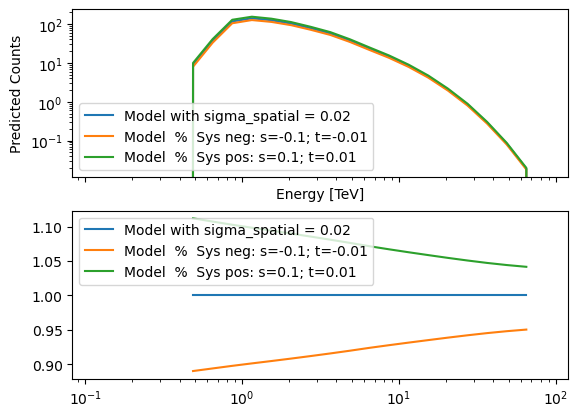

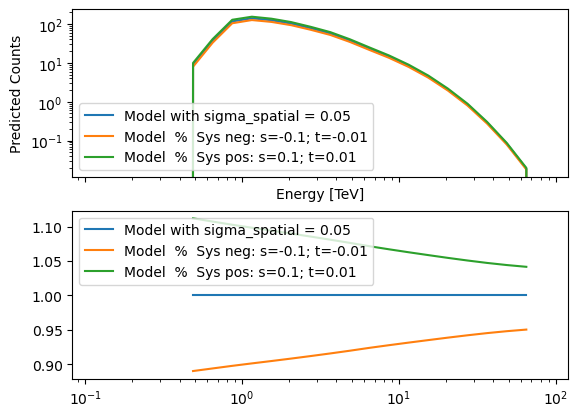

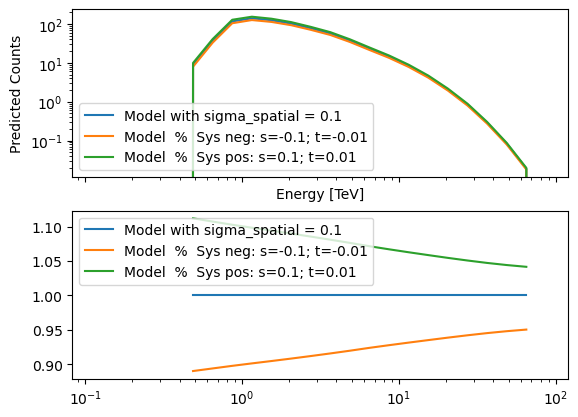

In [11]:
for i, a in enumerate(sigma_spatial_array):
    dataset_asimov = dataset_asimov_array[i]
    dataset_neg = datasets_array[i][0]
    dataset_cor = datasets_array[i][1]
    dataset_pos = datasets_array[i][2]
    
    fig,ax = plt.subplots(2,1, sharex = True)

    energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

    npred =     dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1) #or (dataset_cor.counts - dataset_cor.background)
    npred_neg = dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
    npred_pos = dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)


    ax[0].plot(true_energy, npred, label = f"Model with sigma_spatial = {a}")
    ax[0].plot(true_energy, npred_neg, 
             label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}")
    ax[0].plot(true_energy, npred_pos,  
             label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}")


    ax[0].loglog()
    ax[0].legend()
    ax[0].set_xlabel("Energy [TeV]")
    ax[0].set_ylabel("Predicted Counts")


    ax[1].plot(true_energy, npred/npred, label = f"Model with sigma_spatial = {a} ")
    ax[1].plot(true_energy, npred_neg/npred, 
             label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}")
    ax[1].plot(true_energy, npred_pos/npred,  
             label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}")

    ax[1].legend()
    ax[1].set_xscale('log')
    fig = plt.gcf()
    fig.savefig(f"plots/1d_counts_s{a}.pdf")

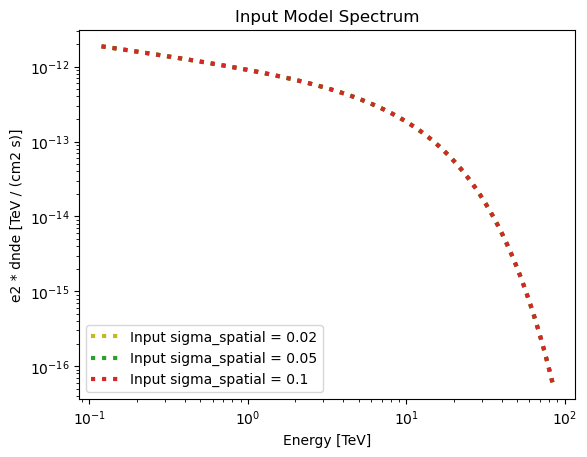

In [12]:
for i, a in enumerate(sigma_spatial_array):
    colors = ['tab:olive', 'tab:green', 'tab:red']
    energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
    #dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
    #dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
    #dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
    dataset_asimov_array[i].models['Source'].spectral_model.plot(energy_bounds, energy_power = 2,
                                    label = f"Input sigma_spatial = {a}", color = colors[i], linewidth = 3, linestyle ='dotted')
    plt.title("Input Model Spectrum")
    plt.legend()

In [13]:
%%time
for i, a in enumerate(sigma_spatial_array):
    print(a)
    #dataset_neg = datasets_array[i][0]
    #dataset_cor = datasets_array[i][1]
    #dataset_pos = datasets_array[i][2]
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run([datasets_array[i][1]])
    fit_neg = Fit(store_trace=False)
    result_neg = fit_neg.run([datasets_array[i][0]])
    fit_pos = Fit(store_trace=False)
    result_pos = fit_pos.run([datasets_array[i][2]])
    #print(result_pos)

0.02
0.05
0.1
CPU times: total: 16.5 s
Wall time: 16.6 s


In [14]:
amplitudes_array = []
indices_array = []
norms_array = []
lambdas_array = []
for i, a in enumerate(sigma_spatial_array):
    print(a)
    print(i)
    datasets_short = datasets_array[i]
    dataset_neg = datasets_array[i][0]
    dataset_cor = datasets_array[i][1]
    dataset_pos = datasets_array[i][2]
    dataset_asimov = dataset_asimov_array[i]
    
    print("Best Fit amplitude")
    amplitudes = []
    m = dataset_asimov.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print('====')
    print('Input')
    print(f'{value} pm {error}')
    print('====')
    for d in datasets_short:
        m = d.models['Source']
        value = m.parameters['amplitude'].value 
        error = m.parameters['amplitude'].error
        amplitudes.append((value, error))
        print(f'{value} pm {error}')
    print()
    print("Best Fit Index")
    indices = []
    m = dataset_asimov.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print('====')
    print('Input')
    print(f'{value} pm {error}')
    print('====')
    for d in datasets_short:
        m = d.models['Source']
        value = m.parameters['index'].value 
        error = m.parameters['index'].error
        indices.append((value, error))
        print(f'{value} pm {error}')
    print()

    print("Best Fit bkg Norm")
    norms = []
    value = dataset_asimov.background_model.parameters['norm'].value 
    error = dataset_asimov.background_model.parameters['norm'].error
    norms.append((value, error))
    print('====')
    print('Input')
    print(f'{value} pm {error}')
    print('====')
    for d in datasets_short:
        value = d.background_model.parameters['norm'].value 
        error = d.background_model.parameters['norm'].error
        print(f'{value} pm {error}')
        norms.append((value, error))
    print()   

    print("Best Fit Lambda")
    lambdas = []
    value = dataset_asimov.models.parameters['lambda_'].value 
    error = dataset_asimov.models.parameters['lambda_'].error
    lambdas.append((value, error))
    print('====')
    print('Input')
    print(f'{value} pm {error}')
    print('====')
    for d in datasets_short:
        value = d.models.parameters['lambda_'].value 
        error = d.models.parameters['lambda_'].error
        print(f'{value} pm {error}')
        lambdas.append((value, error))
    print()
    
    amplitudes_array.append(amplitudes)
    indices_array.append(indices)
    norms_array.append(norms)
    lambdas_array.append(lambdas)
    
    with open(f'data/1d_norms_s{a}.yaml', 'w') as file:
        documents = yaml.dump(norms, file)
    with open(f'data/1d_amplitudes_s{a}.yaml', 'w') as file:
        documents = yaml.dump(amplitudes, file)
    with open(f'data/1d_indices_s{a}.yaml', 'w') as file:
        documents = yaml.dump(indices, file)
    with open(f'data/1d_lambdas_s{a}.yaml', 'w') as file:
        documents = yaml.dump(lambdas, file)

    dataset_neg.models.write(f"data/1d_model_neg_s{a}.yml", overwrite= True)
    dataset_pos.models.write(f"data/1d_model_pos_s{a}.yml", overwrite= True)
    dataset_cor.models.write(f"data/1d_model_cor_s{a}.yml", overwrite= True)

0.02
0
Best Fit amplitude
====
Input
1e-12 pm 0
====
1.1130293778088317e-12 pm 1.3652786572238134e-13
1e-12 pm 1.2341778557925224e-13
9.116015821561485e-13 pm 1.1211256378598155e-13

Best Fit Index
====
Input
2.3 pm 0
====
2.316708172475992 pm 0.15756444749802362
2.3 pm 0.15723862830492105
2.281983340799608 pm 0.15781426899675824

Best Fit bkg Norm
====
Input
1.0 pm 0
====
1.0000019642153872 pm 0.0020665109223784693
1.0 pm 0.0020630035071734884
1.0000075529485888 pm 0.002066528089254004

Best Fit Lambda
====
Input
0.1 pm 0
====
0.10041210194202617 pm 0.04762579339931406
0.1 pm 0.04762308948792854
0.10179002935034738 pm 0.04787593441241588

0.05
1
Best Fit amplitude
====
Input
1e-12 pm 0
====
1.1133965122430092e-12 pm 1.4708749379491542e-13
1e-12 pm 1.326810083659693e-13
9.12191781529007e-13 pm 1.2090171252353764e-13

Best Fit Index
====
Input
2.3 pm 0
====
2.316911176206104 pm 0.1662239796679544
2.3 pm 0.1679822542650013
2.281382164339162 pm 0.16658749550534932

Best Fit bkg Norm
====


In [15]:
print(datasets_array[2][0])

MapDataset
----------

  Name                            : H2UuNDJ2 

  Total counts                    : 361085 
  Total background counts         : 360331.31
  Total excess counts             : 754.34

  Predicted counts                : 361088.90
  Predicted background counts     : 360334.66
  Predicted excess counts         : 754.24

  Exposure min                    : 1.81e-01 m2 s
  Exposure max                    : 2.30e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752373.06

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Paramete

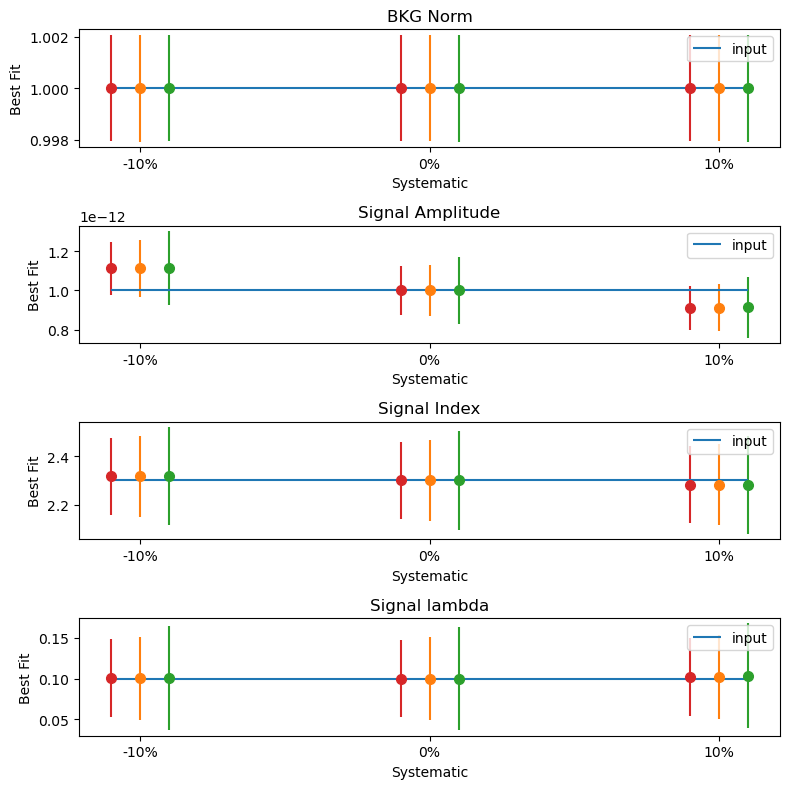

In [16]:
fig, axs = plt.subplots(4,1, figsize=(8,8))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")
axs[3].set_title("Signal lambda")


labels = ['-10%', '0%', '10%']

colors = ['tab:red', 'tab:orange', 'tab:green']

k = 0.2/(len(sigma_spatial_array)-1.)

for j, A in enumerate(sigma_spatial_array):
    amplitudes = amplitudes_array[j]
    indices = indices_array[j]
    norms = norms_array[j]
    lambdas = lambdas_array[j]
    for i, a in enumerate(norms[1:]):
        axs[0].errorbar(x= i+1-k+j*k, y = a[0], yerr = a[1], fmt= 'o', color =  colors[j], markersize=7)
    
    for i, a in enumerate(amplitudes[1:]):
        axs[1].errorbar(x= i+1-k+j*k, y = a[0], yerr = a[1], fmt= 'o', color =  colors[j], markersize=7)

    for i, a in enumerate(indices[1:]):
        axs[2].errorbar(x= i+1-k+j*k, y = a[0], yerr = a[1], fmt= 'o', color =  colors[j], markersize=7)

    for i, a in enumerate(lambdas[1:]):
        axs[3].errorbar(x= i+1-k+j*k, y = a[0], yerr = a[1], fmt= 'o', color =  colors[j], markersize=7)
        
axs[0].hlines( norms[0][0], 1-k, 3+k, label = f"input")
axs[1].hlines( amplitudes[0][0], 1-k, 3+k, label = f"input")
axs[2].hlines( indices[0][0], 1-k, 3+k, label = f"input")
axs[3].hlines( lambdas[0][0], 1-k, 3+k, label = f"input")

plt.tight_layout()
for a in axs:
    a.legend();
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)
plt.tight_layout()    
fig.savefig(f"plots/1d_best_fit_parameters_standard_sigma_spatial.pdf")   


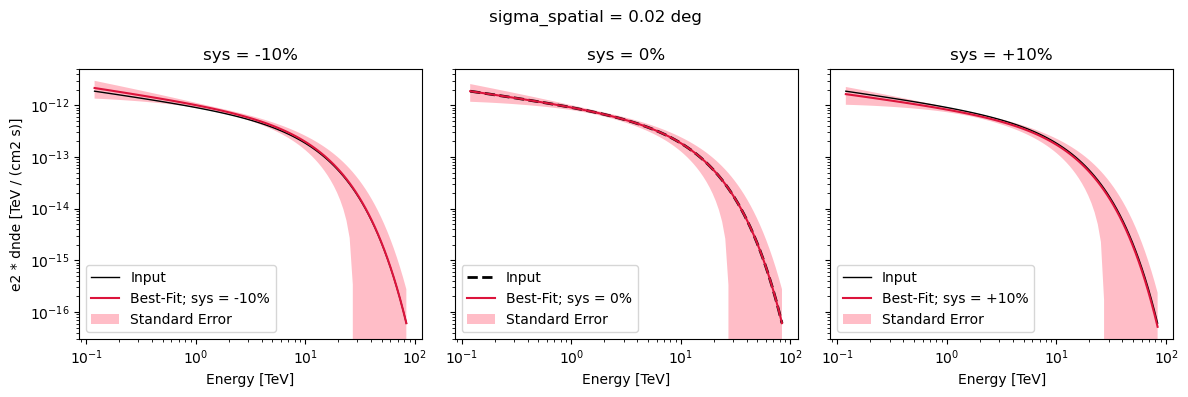

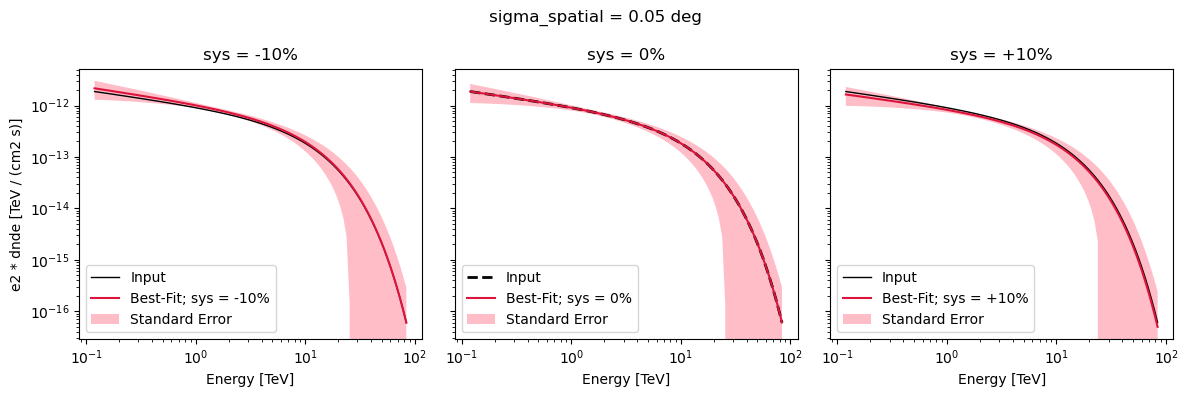

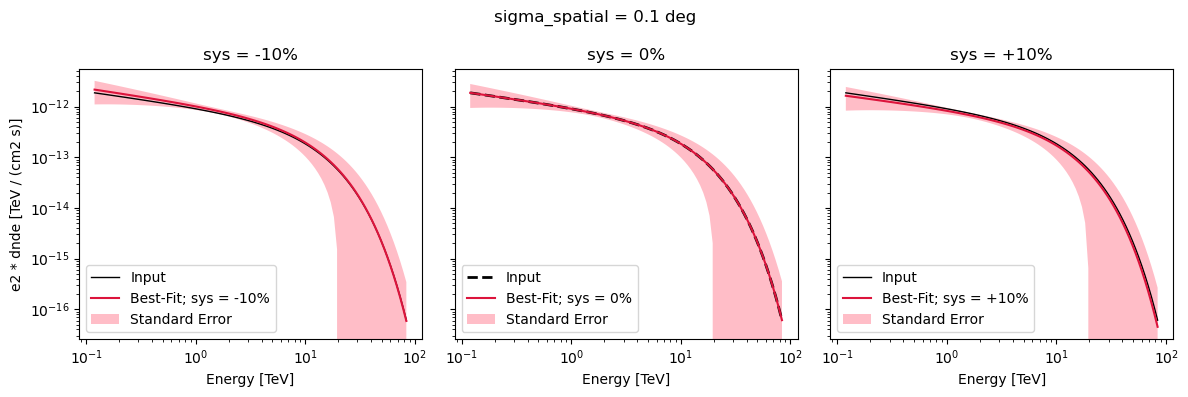

In [17]:
for i, A in enumerate(sigma_spatial_array):
    dataset_asimov = dataset_asimov_array[i]
    dataset_neg = datasets_array[i][0]
    dataset_cor = datasets_array[i][1]
    dataset_pos = datasets_array[i][2]
    
    energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

    fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

    for i,ax in enumerate(axs):
        if i ==1:
             dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                    label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
        else:
            dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                    label = "Input", color = 'black', linewidth = 1, )

    dataset_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                    label = "Best-Fit; sys = -10%", color = "crimson")
    dataset_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                           facecolor='lightpink',
                                                              alpha = 0.9,
                                                              label= "Standard Error"
                                                             )

    dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                    label = "Best-Fit; sys = 0%", color = "crimson")
    dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                           facecolor='lightpink',
                                                              alpha = 0.9,
                                                              label= "Standard Error"
                                                             )

    dataset_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                    label = "Best-Fit; sys = +10%", color = "crimson")
    dataset_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                           facecolor='lightpink',
                                                              alpha = 0.9,
                                                              label= "Standard Error"
                                                             )
    [a.legend() for a in axs]
    axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

    axs[1].set_ylabel('')
    axs[2].set_ylabel('')
    
    plt.suptitle(f'sigma_spatial = {A} deg')
    
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(f"plots/1d_spectrum_standard_s{A}.pdf")

In [18]:
print(datasets_array[2][0])

MapDataset
----------

  Name                            : H2UuNDJ2 

  Total counts                    : 361085 
  Total background counts         : 360331.31
  Total excess counts             : 754.34

  Predicted counts                : 361088.90
  Predicted background counts     : 360334.66
  Predicted excess counts         : 754.24

  Exposure min                    : 1.81e-01 m2 s
  Exposure max                    : 2.30e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752373.06

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Paramete